In [43]:
import numpy as np
import scipy as sp
import sympy as sm
import pandas as pd

import bottleneck as bn
import numexpr as ne
import numba as nb

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
sns.set_style("dark")

In [44]:
from math import sin, cos, sqrt, atan2, radians

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor

In [46]:
import xgboost as xgd

Dataset:

House Price Prediction Challenge - https://www.kaggle.com/anmolkumar/house-price-prediction-challenge

Predict the house prices in India

| Column | Description  |
| --- | --- |
| POSTED_BY          | Category marking who has listed the property|
| UNDER_CONSTRUCTION | Under Construction or Not|
| RERA               | Rera approved or Not|
| BHK_NO             | Number of Rooms|
| BHKORRK            | Type of property|
| SQUARE_FT          | Total area of the house in square feet|
| READYTOMOVE        | Category marking Ready to move or Not|
| RESALE             | Category marking Resale or not|
| ADDRESS            | Address of the property|
| LONGITUDE          | Longitude of the property|
| LATITUDE           | Latitude of the property|



Выведем первые 5 записей датасета.
Как видно, адрес представляет собой строку, и выделить признак из нее очень тяжело,

In [47]:
# defines dataframe
df = pd.read_csv('../input/house-price-prediction-challenge/train.csv')
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


Отобразим информацию о типах данных и нулевых значениях.

Нулевых значений нет, не придется заполнить их.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


Выведем основные статистики по столбцам.

Видно выбросы в столбцах цены и площади, попробуем отделить верные данные от ошибочных.

In [49]:
df.describe()


,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


Отрисуем гистрограммы по численным столбцам.
Как видно, широта, цена и площадь имеют выбросы, так как их гистограммы имеют широкий диапозон значений, хотя почти все значения
находятся в 1 столбце.

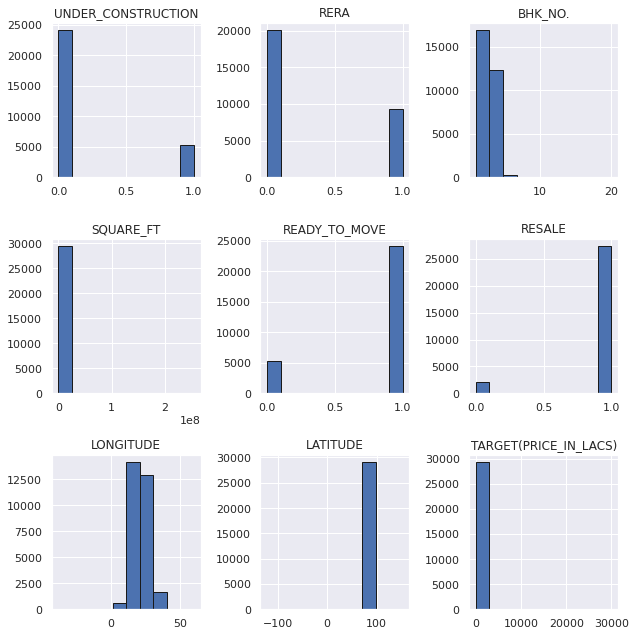

In [50]:
df.hist(figsize=(9,9),ec='k')
plt.tight_layout()

Отрисуем "ящик с усами" для цены.

Как видно, выборка очень зашумлена. Отсеем по квантили 0.95 значения.

<AxesSubplot:>

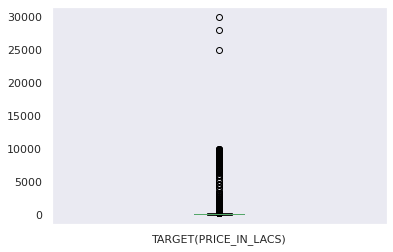

In [51]:
price=df['TARGET(PRICE_IN_LACS)']
price.plot.box()

In [52]:
q=np.quantile(price,0.95)

Гистограмма и ящик с усами для цены без выбросов.

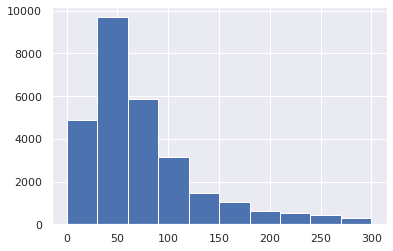

<AxesSubplot:>

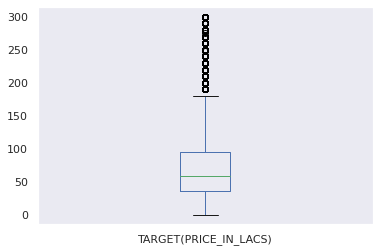

In [53]:
price[price<=q].hist()
plt.show()
price[price<=q].plot.box()

Аналогичную операцию произведем для площади.

<AxesSubplot:>

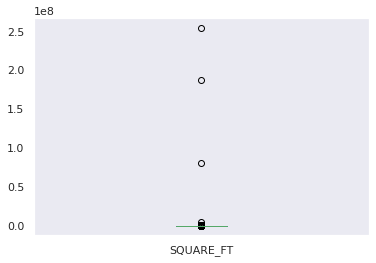

In [54]:
area=df['SQUARE_FT']
area.plot.box()

In [55]:
q2=np.quantile(area,0.95)

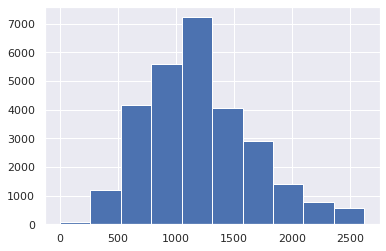

<AxesSubplot:>

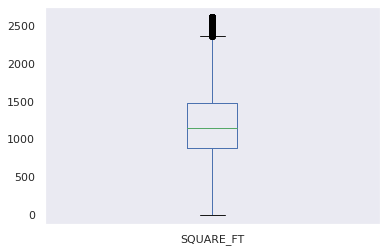

In [56]:
area[area<=q2].hist()
plt.show()
area[area<=q2].plot.box()


In [57]:
df=df[price<q]
df=df[area<q2]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Чтобы убрать из выборки выбросы по широи долготе, а также чтобы выделить признак - штат, отрусем карту Земли
с Индией, на ней отметим положение квартир (цвет означает цену - чем он краснее, тем она больше)

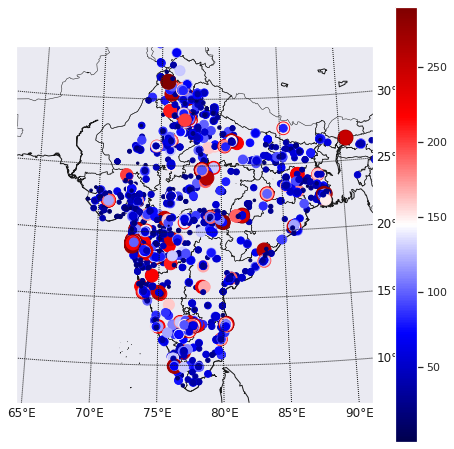

In [58]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap
import matplotlib.path as mpltPath
# fig, ax = plt.subplots(figsize=(8, 8))
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='l',
            width=3E6, height=3E6,
            lat_0=20.6, lon_0=77.8)


lat=df['LATITUDE'].to_numpy()
lon=df['LONGITUDE'].to_numpy()
x_proj,y_proj=arr=m(lat,lon)
price=df['TARGET(PRICE_IN_LACS)']

# m.etopo(scale=0.5, alpha=0.5)
# m.shadedrelief()
# m.drawmapboundary(fill_color='aqua')
# m.fillcontinents(color='white',lake_color='aqua')

m.drawcountries()
m.drawcoastlines()

m.readshapefile('../input/d/wkafan003/india-shape/India_SHP/INDIA','INDIA')
# m.bluemarble()
# meridians on bottom and left
parallels = np.arange(0.,40,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(60.,100.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True])

plt.scatter(arr[0],arr[1],c=price,s=price/1.3,zorder=2,cmap='seismic')
plt.colorbar()
# plt.draw()



Из shape файла были загружены прямоугольники, которые определяют штаты, чтобы узнать принадлежность
квартиры к штату, напишем функцию проверки принадлежности точки к многоугольнику.

In [59]:
@nb.njit
def point_in_polygon(x,y,polygon):
    inside=False
    # x,y=point[0],point[1]
    nvert=polygon.shape[0]
    for i in range(nvert):
        j=(i+1)%nvert
        xp0=polygon[i,0]
        yp0=polygon[i,1]
        xp1=polygon[j,0]
        yp1=polygon[j,1]
        if (yp0 <= y) & (yp1 > y) | (yp1 <= y) & (yp0 > y):
            cross = (xp1 - xp0) * (y - yp0) / (yp1 - yp0) + xp0
            if cross < x:
                inside = not inside

    return inside
def polygon_area(polygon):
    x=polygon[:,0]
    y=polygon[:,1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

Определим штат для каждой квартиры, путем нахождения принадлежности точек (квартир) штатам (многоугольникам).
Предварительно отсортируем штаты по площади, чтобы ускорить поиск, который останавливается при срабатывании вхождения точки
в многоугольник.

In [60]:
from numba.typed import List
states=[[np.array(m.INDIA[i]),
         m.INDIA_info[i]['ST_NAME'],
         ] for i in range(len(m.INDIA))]
states=[(i[0],i[1],polygon_area(i[0])) for i in states]
states.sort(key=lambda x:-x[2])

states_polygons=List()
for i in range(len(states)):
    states_polygons.append(states[i][0])
states_names=[i[1] for i in states]



In [61]:
@nb.njit
def get_state(x,y,states_polygons):
    # point=[x,y]
    # state='NaN'
    state=-1
    for i in range(len(states_polygons)):
        # if  states[i][0].contains_point(point):
        if  point_in_polygon(x,y,states_polygons[i]):
            state=i
            break
    return state

@nb.njit(parallel=True)
def find_states(x,y,states_polygons):
    st = np.empty(x.shape[0],dtype=np.int8)
    for i in nb.prange(st.shape[0]):
        st[i]=get_state(x[i],y[i],states_polygons)
    return st

In [62]:
st=find_states(x_proj,y_proj,states_polygons)

In [63]:
st_names=np.empty(st.shape[0],dtype='|U64')
for i in range(st.shape[0]):
    if st[i]==-1:
        st_names[i]='NaN'
    else:
        st_names[i]=states_names[st[i]]

In [64]:
df['state']=st_names

Выведем статистику по штатам.

In [65]:
df['state'].value_counts()

Maharashtra          6976
Karnataka            4105
Uttar Pradesh        3972
Haryana              1945
West Bengal          1834
Rajasthan            1412
Gujarat              1380
Tamil Nadu           1366
Punjab                740
Madhya Pradesh        631
Andhra Pradesh        496
Kerala                351
Orissa                274
NaN                   262
Jharkhand             256
CHANDIGARH            203
Uttarakhand           186
Goa                   175
Chhattisgarh          173
Bihar                 149
Nct Of Delhi          107
Assam                  98
Himachal Pradesh       41
Pondicherry            13
Jammu And Kashmir       7
Tripura                 1
Manipur                 1
Name: state, dtype: int64

Удалим те записи, которые не находятся в Индии(выбросы).

In [66]:
df=df[df['state']!='NaN']

Отрисуем гистраммы данных после предобработки.

Теперь нет выбросов.

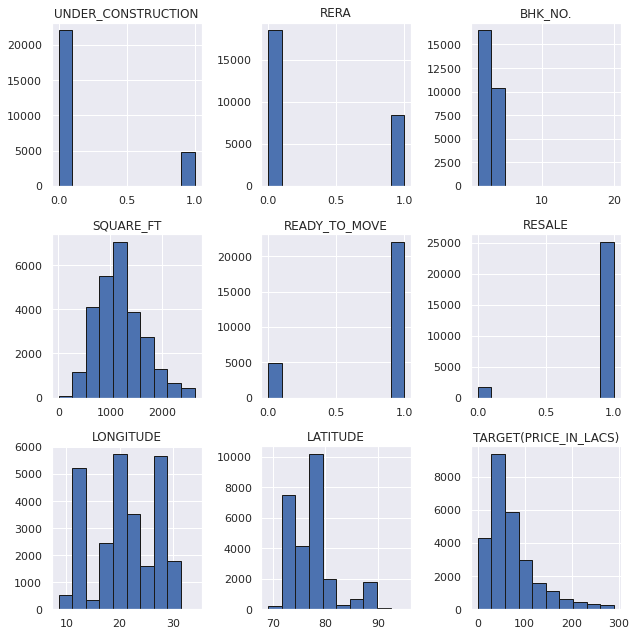

In [67]:
df.hist(figsize=(9,9),ec='k')
plt.tight_layout()



Разделим выборку на обучающуюся и тестовую.


In [68]:
x,y=df.drop(['TARGET(PRICE_IN_LACS)'],axis=1),df['TARGET(PRICE_IN_LACS)']

Произведем трансформацию столбцов - численные нормализуем, категориальные переведем в one hot encoding.
Строки выкинем, так как линейный линейный классификатор не может с ними работать.

In [87]:
model_preprocess=ColumnTransformer([
    ('standart_scale', StandardScaler(),['SQUARE_FT','LONGITUDE','LATITUDE']),
    ('original_encode',OrdinalEncoder(categories=[['BHK','RK']]),['BHK_OR_RK']),
    ('ohe',OneHotEncoder(sparse=False),['POSTED_BY',]),
    ('drop','drop',['ADDRESS','state'])
],
    remainder='passthrough')

In [88]:
x1,x2,y1,y2=train_test_split(x,y,test_size=0.2)
x1=model_preprocess.fit_transform(x1)
x2=model_preprocess.transform(x2)

Обучим модель линейного стохастического градиента.

Принцип работы - итеративая подстройка линейного классификатора с помощью градиентного спуска.

В качестве ошибки будем принимать абсолютную среднюю ошибку - она более устойчива к нестандартным значениям,
чем средний квадрат ошибки.

Ошибка составила примерно 30

In [71]:
model =make_pipeline(StandardScaler(),SGDRegressor())
y_model=model.fit(x1,y1).predict(x2)
mean_absolute_error(y2,y_model)

30.451751029693913

Применим метод ближайших соседей - он основан на поиске ближайших соседей в метрическом пространстве
и усреднении их целевого значения.

In [72]:
model =make_pipeline(StandardScaler(),KNeighborsRegressor())
y_model=model.fit(x1,y1).predict(x2)
mean_absolute_error(y2,y_model)

21.208348763710728

Ошибка уменьшилась и составила примерно 21

Обучим модель метода опорных векторов, который ищет разделяющую поверхность, максимизирующую
дистанцию от объектов разных классов.

In [89]:
model =make_pipeline(StandardScaler(),SVR())
y_model=model.fit(x1,y1).predict(x2)
mean_absolute_error(y2,y_model)

25.62888579137707

Ошибка стала меньше чем у SGD, но больше, чем у knn и примерно равна 25

Чтобы еще уменьшить ошибку - выделим новый признак, "престиж", для этого напишем свою реализацию класса
Estimator, который внутри находит удельную цену квартир поблизости и рассчитывает приблизительную цену для нового объекта.

Расстояние считается из приближения, что земля - идеальный шар.

In [74]:
@nb.njit
def latlon_dist(lat1,lon1,lat2,lon2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # approximate radius of earth in km
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance
@nb.njit
def wraper_latlon_dist(x,y):
    return latlon_dist(x[0],x[1],y[0],y[1])


KnnPrice прогнозирует престиж непрерывно, а KnnPrice2 делит на n классов (можно интерпретировать как
плохой район... престижный район)

In [75]:
class KnnPrice(BaseEstimator,):

    def __init__(self, lat='LATITUDE',lon='LONGITUDE',rooms='BHK_NO.',n_neighbors=5,weights='uniform',algorithm='auto'):
        self.rooms=rooms
        self.lat=lat
        self.lon=lon
        self.n_neighbors=n_neighbors
        self.weights=weights
        self.algorithm=algorithm
    def fit(self,x,y):
        price=y/x[self.rooms]
        self.knn=KNeighborsRegressor(n_neighbors=self.n_neighbors,
                                     weights=self.weights,algorithm=self.algorithm,
                                     metric=wraper_latlon_dist)
        self.knn.fit(x[[self.lat,self.lon]],price)
        return self
    def transform(self,x):
        # x['knn_price']=self.knn.predict(x)
        return x.assign(knn_price=self.knn.predict(x[[self.lat,self.lon]]))
        # return x
class KnnPrice2(BaseEstimator,):

    def __init__(self, lat='LATITUDE',lon='LONGITUDE',rooms='BHK_NO.',n_neighbors=5,weights='uniform',algorithm='auto'):
        self.rooms=rooms
        self.lat=lat
        self.lon=lon
        self.n_neighbors=n_neighbors
        self.weights=weights
        self.algorithm=algorithm
    def fit(self,x,y):
        price=y/x[self.rooms]

        target =pd.qcut(price,np.linspace(0,1,6),labels=False)
        self.knn=KNeighborsClassifier(n_neighbors=self.n_neighbors,
                                     weights=self.weights,algorithm=self.algorithm,
                                     metric=wraper_latlon_dist)
        self.knn.fit(x[[self.lat,self.lon]],target)
        return self
    def transform(self,x):
        # x['knn_price']=self.knn.predict(x)
        return x.assign(knn_price=self.knn.predict(x[[self.lat,self.lon]]))

In [76]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),state
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Karnataka
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Karnataka
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Karnataka
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,Uttar Pradesh
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,West Bengal


Создадим новый препроцессор с новым признаком

In [77]:
model_preprocess=make_pipeline(KnnPrice(),ColumnTransformer([
    # ('standart_scale', StandardScaler(),['SQUARE_FT','LONGITUDE','LATITUDE','knn_price']),
    ('standart_scale', StandardScaler(),['SQUARE_FT','LONGITUDE','LATITUDE']),
    ('original_encode',OrdinalEncoder(categories=[['BHK','RK']]),['BHK_OR_RK']),
    ('ohe',OneHotEncoder(sparse=False),['POSTED_BY',]),
    # ('ohe',OneHotEncoder(sparse=False),['POSTED_BY','state']),
    # ('drop','drop',['ADDRESS',])
    # ('drop','drop',['ADDRESS','state'])
],
    remainder='passthrough'),
                                # PolynomialFeatures(degree=2),
                                # SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=50)),
                     )



In [78]:


x1,x2,y1,y2=train_test_split(x,y,test_size=0.2)
x1 = model_preprocess.fit_transform(x1,y1)
x2 = model_preprocess.transform(x2)


Воспользуемся более мощным инструментом - градиентным бустингом, идея которого заключается в
создании ансамбля простых моделей, которые дают суммарный вклад в выход модели и оптимизация происходит
с учетом предыдущих весов преыдущих моделей.

Для поиска гиперпараметров будем использовать ray - библиотеку дял распределенный вычислений,
поиск гиперпараметров это идеально распараллеливаемая операция. Найдем оптимальные параметры глубины, скорости обучения

В качестве библиотеки для градиентного бустинга используем cat boost, так как она может обрабатывать категориальные данные.

In [79]:
!pip install -q  ray[tune] ray[all] tune-sklearn hyperopt catboost
!pip uninstall -q -y dataclasses

In [80]:
import ray

if ray.is_initialized() is False:
    ray.init()

In [81]:
from ray import tune
import hyperopt as hp
from ray.tune.suggest.hyperopt import HyperOptSearch
from catboost import CatBoostClassifier,CatBoostRegressor,Pool

In [82]:
# !cd ~/  && rm -rf ./ray_results

In [83]:
def training_function(config):
    # Hyperparameters
    its,lr,dp=config['iterations'],config['learning_rate'],config['depth']
    cat_features=config['cat_features']
    model = CatBoostRegressor(its,learning_rate=lr,depth=dp,eval_metric='MAE')

    y_model=model.fit(x1,y1,eval_set=(x2,y2),verbose=False,cat_features=cat_features,
                      metric_period=100).predict(x2)
    intermediate_score = mean_absolute_error(y2,y_model)
    # print(intermediate_score)
    # intermediate_score = np.count_nonzero(y_model == y_test) / len(y_test)
        # Feed the score back back to Tune.
    tune.report(score=intermediate_score)
    return None

config = {
        'iterations':3000,
        'learning_rate':tune.uniform(0.01,1),
        'depth':tune.choice([1,2,3,4,5]),
        'cat_features':np.array([12,13])
}


hyperopt = HyperOptSearch(metric="score", mode="min")
analysis = tune.run(
    training_function,
    mode="min",
    name='my_optim',
    num_samples=10,
    # search_alg=hyperopt,
    config=config)



Trial name,status,loc,depth,learning_rate
training_function_08497_00000,RUNNING,,2,0.189619


Result for training_function_08497_00001:
  date: 2021-04-13_05-14-40
  done: false
  experiment_id: 953948127c7a452fa8a4edb43d7b6ebf
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 398
  score: 18.431417244016764
  time_since_restore: 46.60598182678223
  time_this_iter_s: 46.60598182678223
  time_total_s: 46.60598182678223
  timestamp: 1618290880
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00001
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00000,RUNNING,,2,0.189619,,,
training_function_08497_00001,RUNNING,172.19.2.2:398,1,0.497812,1,46.606,18.4314
training_function_08497_00002,RUNNING,,2,0.0726151,,,
training_function_08497_00003,RUNNING,,4,0.40902,,,
training_function_08497_00004,PENDING,,2,0.195715,,,


Result for training_function_08497_00001:
  date: 2021-04-13_05-14-40
  done: true
  experiment_id: 953948127c7a452fa8a4edb43d7b6ebf
  experiment_tag: 1_depth=1,learning_rate=0.49781
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 398
  score: 18.431417244016764
  time_since_restore: 46.60598182678223
  time_this_iter_s: 46.60598182678223
  time_total_s: 46.60598182678223
  timestamp: 1618290880
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00001
  
Result for training_function_08497_00002:
  date: 2021-04-13_05-14-57
  done: false
  experiment_id: a435a2d42ea944e598e0f68c929b0f55
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 401
  score: 14.947117684526768
  time_since_restore: 63.96499848365784
  time_this_iter_s: 63.96499848365784
  time_total_s: 63.96499848365784
  timestamp: 1618290897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00002
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00000,RUNNING,,2,0.189619,,,
training_function_08497_00002,RUNNING,172.19.2.2:401,2,0.0726151,1,63.965,14.9471
training_function_08497_00003,RUNNING,,4,0.40902,,,
training_function_08497_00004,RUNNING,,2,0.195715,,,
training_function_08497_00005,PENDING,,3,0.0307535,,,
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314


Result for training_function_08497_00002:
  date: 2021-04-13_05-14-57
  done: true
  experiment_id: a435a2d42ea944e598e0f68c929b0f55
  experiment_tag: 2_depth=2,learning_rate=0.072615
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 401
  score: 14.947117684526768
  time_since_restore: 63.96499848365784
  time_this_iter_s: 63.96499848365784
  time_total_s: 63.96499848365784
  timestamp: 1618290897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00002
  
Result for training_function_08497_00000:
  date: 2021-04-13_05-14-59
  done: false
  experiment_id: 93a8226a8e0d4b049a4312a711791139
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 400
  score: 14.642999992202109
  time_since_restore: 66.50356101989746
  time_this_iter_s: 66.50356101989746
  time_total_s: 66.50356101989746
  timestamp: 1618290899
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00000
  
Result for trainin

Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00003,RUNNING,,4,0.40902,,,
training_function_08497_00004,RUNNING,172.19.2.2:684,2,0.195715,1,64.5259,14.6452
training_function_08497_00005,RUNNING,,3,0.0307535,,,
training_function_08497_00006,RUNNING,,2,0.75078,,,
training_function_08497_00007,PENDING,,2,0.992778,,,
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471


Result for training_function_08497_00004:
  date: 2021-04-13_05-15-51
  done: true
  experiment_id: a4cf01a4d33648e48c917822fa36549a
  experiment_tag: 4_depth=2,learning_rate=0.19571
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 684
  score: 14.645205800113839
  time_since_restore: 64.52589654922485
  time_this_iter_s: 64.52589654922485
  time_total_s: 64.52589654922485
  timestamp: 1618290951
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00004
  
Result for training_function_08497_00003:
  date: 2021-04-13_05-15-58
  done: false
  experiment_id: a17c0e3a4f5741aa839b7b769c57acf3
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 564
  score: 13.757660990058657
  time_since_restore: 122.33354711532593
  time_this_iter_s: 122.33354711532593
  time_total_s: 122.33354711532593
  timestamp: 1618290958
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00003
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00003,RUNNING,172.19.2.2:564,4,0.40902,1,122.334,13.7577
training_function_08497_00005,RUNNING,,3,0.0307535,,,
training_function_08497_00006,RUNNING,,2,0.75078,,,
training_function_08497_00007,RUNNING,,2,0.992778,,,
training_function_08497_00008,PENDING,,1,0.260938,,,
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471
training_function_08497_00004,TERMINATED,,2,0.195715,1,64.5259,14.6452


Result for training_function_08497_00003:
  date: 2021-04-13_05-15-58
  done: true
  experiment_id: a17c0e3a4f5741aa839b7b769c57acf3
  experiment_tag: 3_depth=4,learning_rate=0.40902
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 564
  score: 13.757660990058657
  time_since_restore: 122.33354711532593
  time_this_iter_s: 122.33354711532593
  time_total_s: 122.33354711532593
  timestamp: 1618290958
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00003
  
Result for training_function_08497_00006:
  date: 2021-04-13_05-16-16
  done: false
  experiment_id: 4da9c0b3cda1496a9c5692c1a2192ae1
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 753
  score: 14.6470875706341
  time_since_restore: 68.21108961105347
  time_this_iter_s: 68.21108961105347
  time_total_s: 68.21108961105347
  timestamp: 1618290976
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00006
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00005,RUNNING,,3,0.0307535,,,
training_function_08497_00006,RUNNING,172.19.2.2:753,2,0.75078,1,68.2111,14.6471
training_function_08497_00007,RUNNING,,2,0.992778,,,
training_function_08497_00008,RUNNING,,1,0.260938,,,
training_function_08497_00009,PENDING,,3,0.70131,,,
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471
training_function_08497_00003,TERMINATED,,4,0.40902,1,122.334,13.7577
training_function_08497_00004,TERMINATED,,2,0.195715,1,64.5259,14.6452


Result for training_function_08497_00006:
  date: 2021-04-13_05-16-16
  done: true
  experiment_id: 4da9c0b3cda1496a9c5692c1a2192ae1
  experiment_tag: 6_depth=2,learning_rate=0.75078
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 753
  score: 14.6470875706341
  time_since_restore: 68.21108961105347
  time_this_iter_s: 68.21108961105347
  time_total_s: 68.21108961105347
  timestamp: 1618290976
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00006
  
Result for training_function_08497_00005:
  date: 2021-04-13_05-16-31
  done: false
  experiment_id: f251823fe33546e0938825e970b7e58e
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 735
  score: 14.688391347453756
  time_since_restore: 86.73629641532898
  time_this_iter_s: 86.73629641532898
  time_total_s: 86.73629641532898
  timestamp: 1618290991
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00005
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00005,RUNNING,172.19.2.2:735,3,0.0307535,1,86.7363,14.6884
training_function_08497_00007,RUNNING,,2,0.992778,,,
training_function_08497_00008,RUNNING,,1,0.260938,,,
training_function_08497_00009,RUNNING,,3,0.70131,,,
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471
training_function_08497_00003,TERMINATED,,4,0.40902,1,122.334,13.7577
training_function_08497_00004,TERMINATED,,2,0.195715,1,64.5259,14.6452
training_function_08497_00006,TERMINATED,,2,0.75078,1,68.2111,14.6471


Result for training_function_08497_00005:
  date: 2021-04-13_05-16-31
  done: true
  experiment_id: f251823fe33546e0938825e970b7e58e
  experiment_tag: 5_depth=3,learning_rate=0.030753
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 735
  score: 14.688391347453756
  time_since_restore: 86.73629641532898
  time_this_iter_s: 86.73629641532898
  time_total_s: 86.73629641532898
  timestamp: 1618290991
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00005
  
Result for training_function_08497_00008:
  date: 2021-04-13_05-16-51
  done: false
  experiment_id: c7a6c1f425ae4b65964cf239908e153d
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 915
  score: 18.475229222553324
  time_since_restore: 42.940202474594116
  time_this_iter_s: 42.940202474594116
  time_total_s: 42.940202474594116
  timestamp: 1618291011
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00008
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00007,RUNNING,,2,0.992778,,,
training_function_08497_00008,RUNNING,172.19.2.2:915,1,0.260938,1,42.9402,18.4752
training_function_08497_00009,RUNNING,,3,0.70131,,,
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471
training_function_08497_00003,TERMINATED,,4,0.40902,1,122.334,13.7577
training_function_08497_00004,TERMINATED,,2,0.195715,1,64.5259,14.6452
training_function_08497_00005,TERMINATED,,3,0.0307535,1,86.7363,14.6884
training_function_08497_00006,TERMINATED,,2,0.75078,1,68.2111,14.6471


Result for training_function_08497_00008:
  date: 2021-04-13_05-16-51
  done: true
  experiment_id: c7a6c1f425ae4b65964cf239908e153d
  experiment_tag: 8_depth=1,learning_rate=0.26094
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 915
  score: 18.475229222553324
  time_since_restore: 42.940202474594116
  time_this_iter_s: 42.940202474594116
  time_total_s: 42.940202474594116
  timestamp: 1618291011
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00008
  
Result for training_function_08497_00007:
  date: 2021-04-13_05-16-59
  done: false
  experiment_id: 99f493a993a54cd8a9b03bc1b330dd34
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 877
  score: 14.797203640069784
  time_since_restore: 57.88299345970154
  time_this_iter_s: 57.88299345970154
  time_total_s: 57.88299345970154
  timestamp: 1618291019
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00007
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00007,RUNNING,172.19.2.2:877,2,0.992778,1,57.883,14.7972
training_function_08497_00009,RUNNING,,3,0.70131,,,
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471
training_function_08497_00003,TERMINATED,,4,0.40902,1,122.334,13.7577
training_function_08497_00004,TERMINATED,,2,0.195715,1,64.5259,14.6452
training_function_08497_00005,TERMINATED,,3,0.0307535,1,86.7363,14.6884
training_function_08497_00006,TERMINATED,,2,0.75078,1,68.2111,14.6471
training_function_08497_00008,TERMINATED,,1,0.260938,1,42.9402,18.4752


Result for training_function_08497_00007:
  date: 2021-04-13_05-16-59
  done: true
  experiment_id: 99f493a993a54cd8a9b03bc1b330dd34
  experiment_tag: 7_depth=2,learning_rate=0.99278
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 877
  score: 14.797203640069784
  time_since_restore: 57.88299345970154
  time_this_iter_s: 57.88299345970154
  time_total_s: 57.88299345970154
  timestamp: 1618291019
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00007
  
Result for training_function_08497_00009:
  date: 2021-04-13_05-17-12
  done: false
  experiment_id: 62ab649434ca4adc8ebc7d6c18908a7d
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 966
  score: 14.145548672150008
  time_since_restore: 47.23516058921814
  time_this_iter_s: 47.23516058921814
  time_total_s: 47.23516058921814
  timestamp: 1618291032
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00009
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00009,RUNNING,172.19.2.2:966,3,0.70131,1,47.2352,14.1455
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471
training_function_08497_00003,TERMINATED,,4,0.40902,1,122.334,13.7577
training_function_08497_00004,TERMINATED,,2,0.195715,1,64.5259,14.6452
training_function_08497_00005,TERMINATED,,3,0.0307535,1,86.7363,14.6884
training_function_08497_00006,TERMINATED,,2,0.75078,1,68.2111,14.6471
training_function_08497_00007,TERMINATED,,2,0.992778,1,57.883,14.7972
training_function_08497_00008,TERMINATED,,1,0.260938,1,42.9402,18.4752


Result for training_function_08497_00009:
  date: 2021-04-13_05-17-12
  done: true
  experiment_id: 62ab649434ca4adc8ebc7d6c18908a7d
  experiment_tag: 9_depth=3,learning_rate=0.70131
  hostname: 8da1837b6ed0
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 966
  score: 14.145548672150008
  time_since_restore: 47.23516058921814
  time_this_iter_s: 47.23516058921814
  time_total_s: 47.23516058921814
  timestamp: 1618291032
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08497_00009
  


Trial name,status,loc,depth,learning_rate,iter,total time (s),score
training_function_08497_00000,TERMINATED,,2,0.189619,1,66.5036,14.643
training_function_08497_00001,TERMINATED,,1,0.497812,1,46.606,18.4314
training_function_08497_00002,TERMINATED,,2,0.0726151,1,63.965,14.9471
training_function_08497_00003,TERMINATED,,4,0.40902,1,122.334,13.7577
training_function_08497_00004,TERMINATED,,2,0.195715,1,64.5259,14.6452
training_function_08497_00005,TERMINATED,,3,0.0307535,1,86.7363,14.6884
training_function_08497_00006,TERMINATED,,2,0.75078,1,68.2111,14.6471
training_function_08497_00007,TERMINATED,,2,0.992778,1,57.883,14.7972
training_function_08497_00008,TERMINATED,,1,0.260938,1,42.9402,18.4752
training_function_08497_00009,TERMINATED,,3,0.70131,1,47.2352,14.1455


2021-04-13 05:17:12,837	INFO tune.py:450 -- Total run time: 202.73 seconds (202.61 seconds for the tuning loop).


Лучшая конфигурация

In [86]:
print("Best config: ", analysis.get_best_config(
    metric="score", mode="min"))


Best config:  {'iterations': 3000, 'learning_rate': 0.4090195804383928, 'depth': 4, 'cat_features': array([12, 13])}


Минимальная абсолютная ошибка

In [90]:
print(analysis.get_best_trial('score').last_result['score'])


13.757660990058657


Как и предполагалось - более сложный метод дает лучшие результаты.
